In [ ]:
pip install pyramid-arima scikit-learn==0.20 fastai==0.7.0

# Importing Libraries

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from pyramid.arima import auto_arima
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# Understanding the Dataset

         Date   Open   High     Low   Close   Volume
0  31-12-2019  334.9  336.3  332.60  333.70   744106
1  30-12-2019  337.8  337.9  332.45  334.25   860732
2  27-12-2019  333.6  338.3  333.05  337.25  1249101
3  26-12-2019  333.0  333.2  328.05  329.85   660165
4  24-12-2019  332.7  334.2  329.25  331.30   750326

 Shape of the data:
(2226, 6)


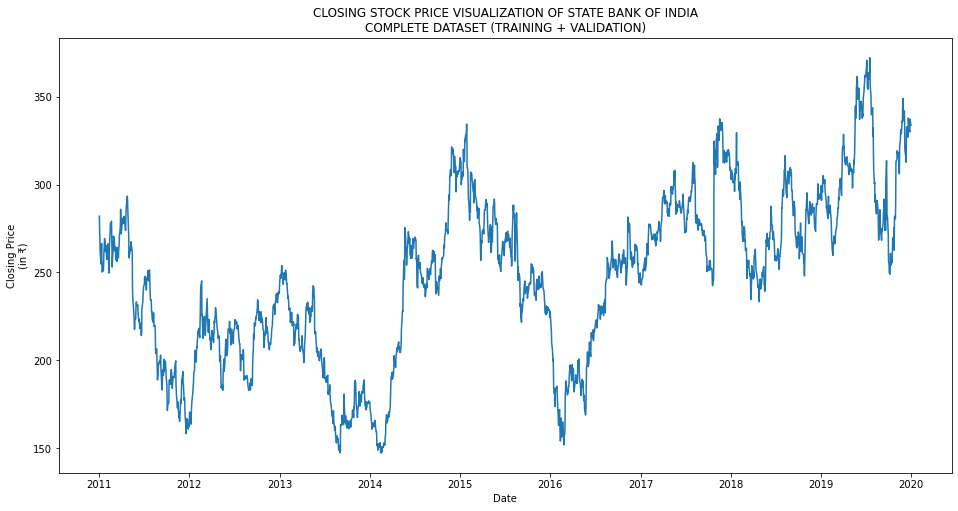

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/dipanshuagarwal/Stock-Market-Forecasting/master/dataset11-19.csv')

print(df.head())
print('\n Shape of the data:')
print(df.shape)

# setting the index as date
df['Date'] = pd.to_datetime(df.Date,format='%d-%m-%Y')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df['Date'], df['Close'])
ax.set(title = "CLOSING STOCK PRICE VISUALIZATION OF STATE BANK OF INDIA\nCOMPLETE DATASET (TRAINING + VALIDATION)",
       xlabel = "Date",
       ylabel = "Closing Price\n(in ₹)")
plt.show()

# Models

### Moving Average

In [4]:
#creating dataframe with date and the target variable
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Close'][i] = data['Close'][i]

# NOTE: While splitting the data into train and validation set, we cannot use random splitting since that will destroy the time component. 
# So here we have set the last year’s data into validation and the 8 years’ data before that into train set.
# splitting into train and validation
train = new_data[:1981]
valid = new_data[1981:]

# shapes of training set
print('\n Shape of training set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)

# In the next step, we will create predictions for the validation set and check the RMSE using the actual values.
# making predictions
preds = []
for i in range(0,valid.shape[0]):
    a = train['Close'][len(train)-245+i:].sum() + sum(preds)
    b = a/245
    preds.append(b)


 Shape of training set:
(1981, 2)

 Shape of validation set:
(245, 2)


**#NOTE: THE SHAPE OF TRAINING AND VALIDATION SET WILL BE SAME FOR ALL THE MODELS, THUS WE WILL NOT PRINT IT AGAIN.** 

In [5]:
# checking the results (RMSE value)
ma_rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
print('\n RMSE value on validation set:')
print(ma_rms)

ma_mape=(np.mean((np.array(valid['Close'])-preds)))
print('\n MAPE value on validation set:')
print(ma_mape)


 RMSE value on validation set:
44.46086937909403

 MAPE value on validation set:
33.3288560620692


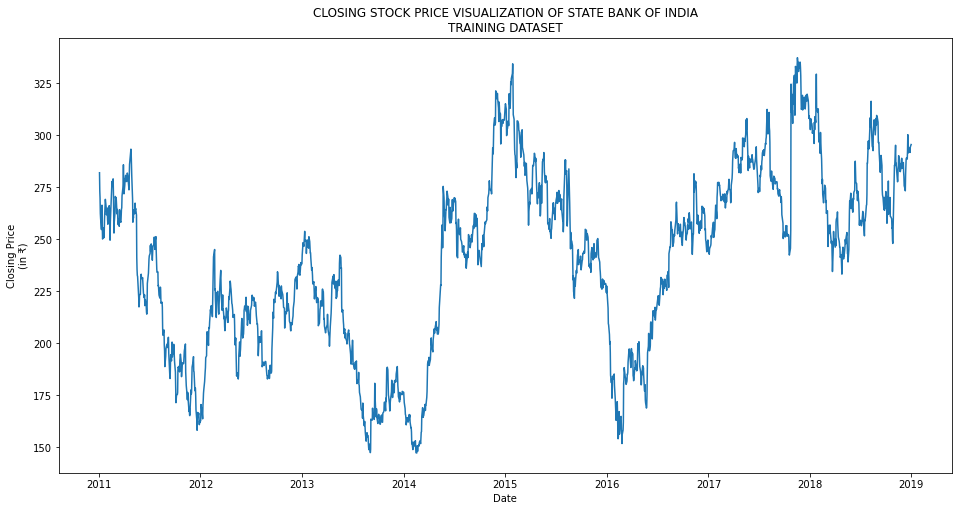

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(train['Date'], train['Close'])
ax.set(title = "CLOSING STOCK PRICE VISUALIZATION OF STATE BANK OF INDIA\nTRAINING DATASET",
       xlabel = "Date",
       ylabel = "Closing Price\n(in ₹)")
plt.show()

**#NOTE: THE TRAINING SET WILL BE SAME FOR ALL THE MODELS, THUS WE WILL NOT PRINT IT AGAIN.** 

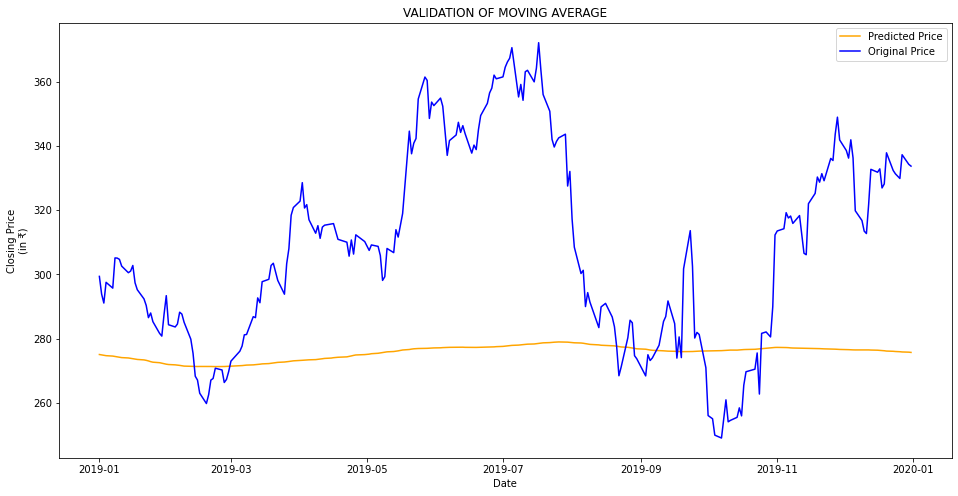

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(valid['Date'],preds, label='Predicted Price', color='orange')
ax.plot(valid['Date'],valid['Close'], label='Original Price', color='blue')
ax.set(title = "VALIDATION OF MOVING AVERAGE",
       xlabel = "Date",
       ylabel = "Closing Price\n(in ₹)")
plt.legend()
plt.show()

### Linear Regression

In [ ]:
#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

date = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    date['Date'][i] = data['Date'][i]
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#create features
from fastai.structured import add_datepart
add_datepart(new_data, 'Date')

new_data['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon_fri'][i] = 1
    else:
        new_data['mon_fri'][i] = 0

#split into train and validation
train = new_data[:1981]
valid = new_data[1981:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

#make predictions
preds = model.predict(x_valid)

In [9]:
lr_rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
print('\n RMS value on validation set:')
print(lr_rms)

lr_mape=np.mean(np.array(np.array(y_valid)-np.array(preds)))
print('\n MAPE value on validation set:')
print(lr_mape)


 RMS value on validation set:
40.079985706550715

 MAPE value on validation set:
27.888435779677646


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



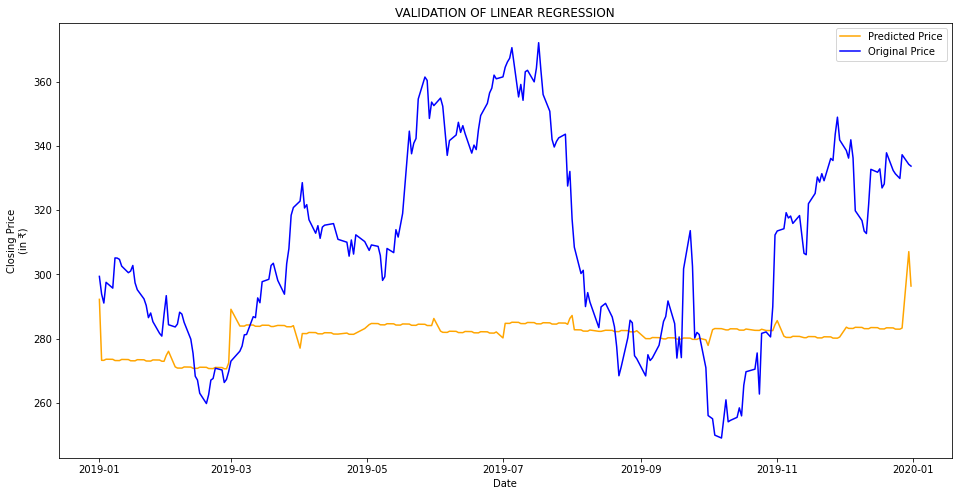

In [10]:
valid['Date'] = date[1981:]['Date']

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(valid['Date'],preds, label='Predicted Price', color='orange')
ax.plot(valid['Date'],valid['Close'], label='Original Price', color='blue')
ax.set(title = "VALIDATION OF LINEAR REGRESSION",
       xlabel = "Date",
       ylabel = "Closing Price\n(in ₹)")
plt.legend()
plt.show()

### KNN

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
date = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    date['Date'][i] = data['Date'][i]
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#create features
from fastai.structured import add_datepart
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp

new_data['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon_fri'][i] = 1
    else:
        new_data['mon_fri'][i] = 0

#split into train and validation
train = new_data[:1981]
valid = new_data[1981:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

In [12]:
knn_rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
print('\n RMS value on validation set:')
print(knn_rms)

knn_mape=np.mean(np.array(np.array(y_valid)-np.array(preds)))
print('\n MAPE value on validation set:')
print(knn_mape)


 RMS value on validation set:
94.68023402139535

 MAPE value on validation set:
87.07895691609978


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



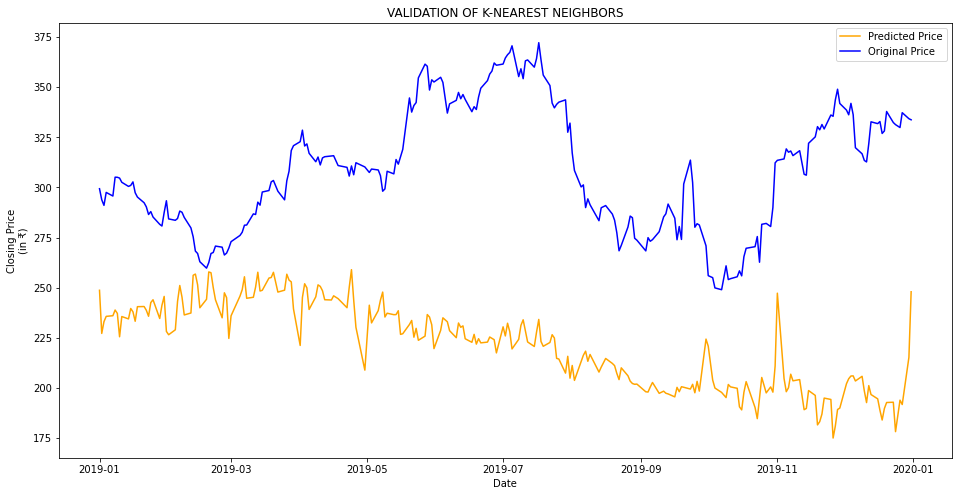

In [13]:
valid['Date'] = date[1981:]['Date']

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(valid['Date'],preds, label='Predicted Price', color='orange')
ax.plot(valid['Date'],valid['Close'], label='Original Price', color='blue')
ax.set(title = "VALIDATION OF K-NEAREST NEIGHBORS",
       xlabel = "Date",
       ylabel = "Closing Price\n(in ₹)")
plt.legend()
plt.show()

### Prophet

In [ ]:
#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%d-%m-%Y')
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:1981]
valid = new_data[1981:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

forecast_valid = forecast['yhat'][1981:]

In [15]:
#rmse
p_rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
print('\n RMS value on validation set:')
print(p_rms)

p_mape=abs(np.mean(np.array(np.array(forecast_valid)-np.array(valid['y']))))
print('\n MAPE value on validation set:')
print(p_mape)


 RMS value on validation set:
50.31837619277186

 MAPE value on validation set:
39.030956806155714


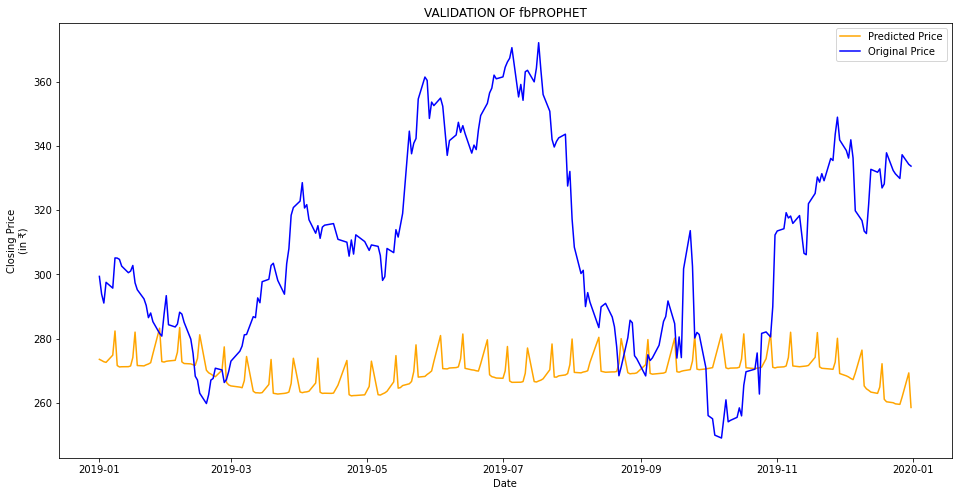

In [16]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(valid['ds'],forecast_valid.values, label='Predicted Price', color='orange')
ax.plot(valid['ds'],valid['y'], label='Original Price', color='blue')
ax.set(title = "VALIDATION OF fbPROPHET",
       xlabel = "Date",
       ylabel = "Closing Price\n(in ₹)")
plt.legend()
plt.show()

### Auto Arima

In [17]:
train = data[:1981]
valid = data[1981:]

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=245)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=11933.830, BIC=11961.754, Fit time=28.300 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=13170.028, BIC=13181.198, Fit time=0.167 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=12647.224, BIC=12669.563, Fit time=3.945 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=11933.118, BIC=11955.457, Fit time=23.781 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=11932.170, BIC=11960.094, Fit time=22.076 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=12646.561, BIC=12668.900, Fit time=5.376 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=11936.583, BIC=11970.092, Fit time=58.038 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=13156.360, BIC=13173.115, Fit time=1.870 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=11933.705, BIC=11972.799, Fit time=41.413 seconds
Fit A

In [18]:
a_rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
print('\n RMS value on validation set:')
print(a_rms)

a_mape=np.mean(np.array(np.array(forecast['Prediction']-np.array(valid['Close']))))
print('\n MAPE value on validation set:')
print(a_mape)


 RMS value on validation set:
31.84104405718795

 MAPE value on validation set:
7.353536006014123


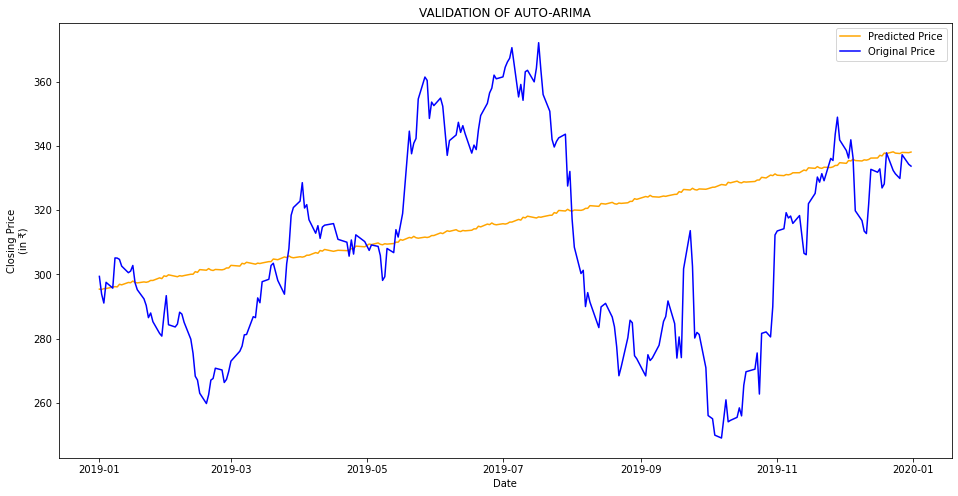

In [19]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(valid['Date'],forecast['Prediction'], label='Predicted Price', color='orange')
ax.plot(valid['Date'],valid['Close'], label='Original Price', color='blue')
ax.set(title = "VALIDATION OF AUTO-ARIMA",
       xlabel = "Date",
       ylabel = "Closing Price\n(in ₹)")
plt.legend()
plt.show()

### Long Short Term Memory

In [20]:
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:1981,:]
valid = dataset[1981:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=32, batch_size=50, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning:

Data with input dtype object was converted to float64 by MinMaxScaler.



Epoch 1/32
 - 4s - loss: 0.0169
Epoch 2/32
 - 3s - loss: 0.0034
Epoch 3/32
 - 3s - loss: 0.0028
Epoch 4/32
 - 3s - loss: 0.0026
Epoch 5/32
 - 3s - loss: 0.0023
Epoch 6/32
 - 3s - loss: 0.0022
Epoch 7/32
 - 3s - loss: 0.0019
Epoch 8/32
 - 3s - loss: 0.0018
Epoch 9/32
 - 3s - loss: 0.0018
Epoch 10/32
 - 3s - loss: 0.0016
Epoch 11/32
 - 3s - loss: 0.0015
Epoch 12/32
 - 3s - loss: 0.0015
Epoch 13/32
 - 3s - loss: 0.0015
Epoch 14/32
 - 3s - loss: 0.0015
Epoch 15/32
 - 3s - loss: 0.0013
Epoch 16/32
 - 4s - loss: 0.0013
Epoch 17/32
 - 6s - loss: 0.0012
Epoch 18/32
 - 3s - loss: 0.0012
Epoch 19/32
 - 3s - loss: 0.0011
Epoch 20/32
 - 3s - loss: 0.0010
Epoch 21/32
 - 3s - loss: 9.9178e-04
Epoch 22/32
 - 3s - loss: 9.8704e-04
Epoch 23/32
 - 3s - loss: 9.4260e-04
Epoch 24/32
 - 3s - loss: 9.2842e-04
Epoch 25/32
 - 3s - loss: 8.6470e-04
Epoch 26/32
 - 3s - loss: 8.0011e-04
Epoch 27/32
 - 3s - loss: 8.2094e-04
Epoch 28/32
 - 3s - loss: 7.7795e-04
Epoch 29/32
 - 3s - loss: 7.5412e-04
Epoch 30/32
 - 3

In [21]:
lstm_rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
print('\n RMS value on validation set:')
print(lstm_rms)

lstm_mape=abs(np.mean(valid-closing_price))
print('\n MAPE value on validation set:')
print(lstm_mape)


 RMS value on validation set:
7.887728502950247

 MAPE value on validation set:
3.546201271524235


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



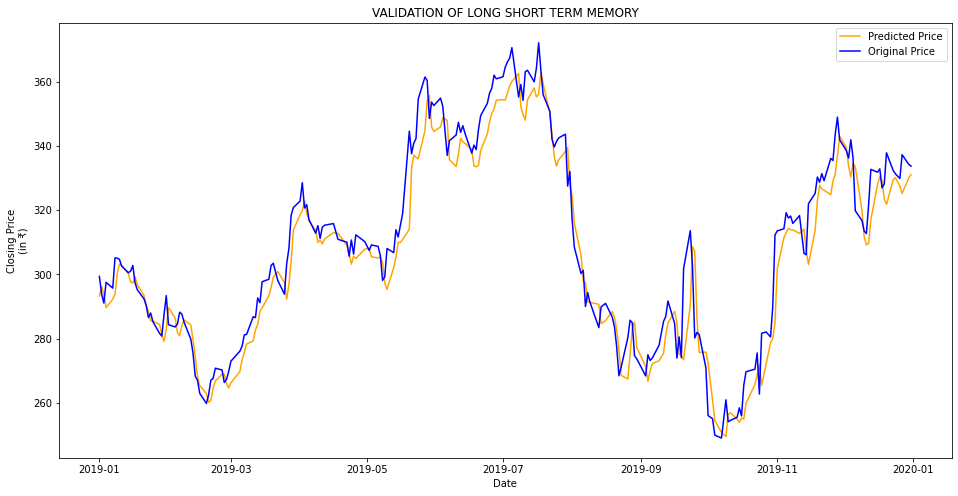

In [22]:
#for plotting
valid = new_data[1981:]
valid['Predictions'] = closing_price
plt.figure(figsize=(16,8))
plt.plot(valid['Predictions'], label='Predicted Price', color='orange')
plt.plot(valid['Close'], label='Original Price', color='blue')
plt.title('VALIDATION OF LONG SHORT TERM MEMORY')
plt.xlabel("Date")
plt.ylabel("Closing Price\n(in ₹)")
plt.legend()
plt.show()

# Comparison

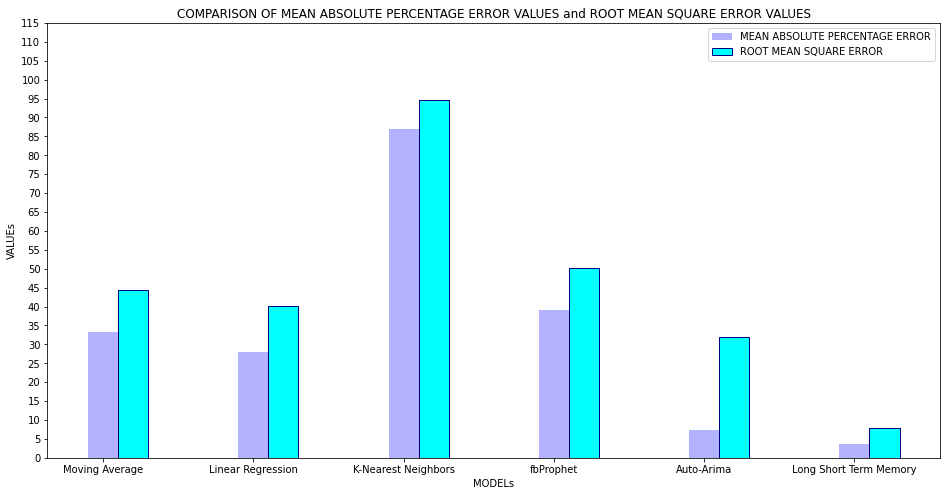

In [23]:
val = [[ma_mape,lr_mape,knn_mape,p_mape,a_mape,lstm_mape],[ma_rms,lr_rms,knn_rms,
                                                           p_rms,a_rms,lstm_rms]]
mods = ['Moving Average', 'Linear Regression', 'K-Nearest Neighbors', 'fbProphet',
        'Auto-Arima', 'Long Short Term Memory']
X = np.arange(6)
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(X + 0.00, val[0], color = 'blue', alpha=0.3, width=0.2, 
       label='MEAN ABSOLUTE PERCENTAGE ERROR')
ax.bar(X + 0.2, val[1], color = 'cyan', edgecolor = 'darkblue', width=0.2, 
       label='ROOT MEAN SQUARE ERROR')
ax.set(title = "COMPARISON OF MEAN ABSOLUTE PERCENTAGE ERROR VALUES and ROOT MEAN SQUARE ERROR VALUES",
       xlabel = "MODELs",
       ylabel = "VALUEs")
ax.set_yticks(np.arange(0, 120, 5))
ax.set_xticks(X)
ax.set_xticklabels([mods[i] for i in X])
plt.legend()
plt.show()